In [58]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from independence import *
from pre_process import *
from constants import *
import warnings
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
warnings.simplefilter("ignore")

In [3]:
df = data_processing("data/NCDOT_BikePedCrash.csv")
features_df = features_engineer("data/NCDOT_BikePedCrash.csv", winter_filter=True)

In [4]:
features_df

,age_category,is_drunk_biker,month,severity,is_drunk_driver,y,x,speed_limit,is_wet,is_male,...,light_condition_Daylight,locality_Mixed (30% To 70% Developed),locality_Rural (<30% Developed),locality_Urban (>70% Developed),road_surface_type_Coarse Asphalt,road_surface_type_Concrete,road_surface_type_Smooth Asphalt,weather_Clear,weather_Cloudy,weather_Rain
0,11,0,1,2,0,36.039490,-78.883896,30,0,1,...,1,0,0,1,0,0,1,1,0,0
1,20,0,1,1,0,35.751118,-78.782800,30,0,1,...,1,0,0,1,0,0,1,1,0,0
2,30,0,1,2,0,35.084732,-80.697820,20,0,1,...,1,0,0,1,0,0,1,0,1,0
3,30,0,1,1,0,35.684400,-80.479320,30,0,1,...,1,0,0,1,0,0,1,0,1,0
4,40,0,1,2,0,34.999428,-78.904450,30,0,1,...,1,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11251,40,0,12,1,0,35.077343,-78.958951,40,0,1,...,1,0,1,0,1,0,0,1,0,0
11253,60,0,12,3,0,35.534234,-77.025772,30,0,0,...,1,0,0,1,1,0,0,1,0,0
11255,30,0,12,2,0,35.118065,-77.077608,30,0,1,...,1,0,0,1,0,0,1,1,0,0
11256,50,0,12,0,0,35.718750,-78.624247,30,0,1,...,1,0,0,1,1,0,0,1,0,0


In [79]:
def calculate_propensity_score(df, model, scale=False):
  df_copy = df.copy()
  X_df = df_copy[PROPENSITY_MODEL_FEATURES]
  t_true = df_copy[T_BINARY]

  if scale:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_df)
  else:
    X_scaled = X_df

  model.fit(X_scaled, t_true)
  propensity_scores = model.predict_proba(X_scaled)[:, 1]
  df_copy['propensity_score'] = propensity_scores
  return df_copy

In [173]:
lr_propensity_df = calculate_propensity_score(features_df, LogisticRegression(max_iter=1000, random_state=42), scale=True)
gb_propensity_df = calculate_propensity_score(features_df, GradientBoostingClassifier(n_estimators=10, max_depth=5, min_samples_leaf=5, learning_rate=0.5, random_state=42), scale=True)
rf_propensity_df = calculate_propensity_score(features_df, RandomForestClassifier(n_estimators=20, max_depth=20, class_weight='balanced_subsample', random_state=42), scale=True)
xgb_propensity_df = xgb_propensity_df = calculate_propensity_score(features_df, xgb.XGBClassifier(n_estimators=50, max_depth=5, learning_rate=0.1, subsample=0.8, random_state=42),scale=True)

In [81]:
def plot_propensity_hist(propensity_df, model):   
    plt.hist(propensity_df[propensity_df[T_BINARY] == 1]['propensity_score'], fc=(0, 0, 1, 0.5), bins=20, label='Treated')
    plt.hist(propensity_df[propensity_df[T_BINARY] == 0]['propensity_score'], fc=(1, 0, 0, 0.5), bins=20, label='Control')
    plt.legend()
    plt.title(f'{model} propensity scores overlap')
    plt.yscale('log')
    plt.xlabel('propensity score')
    plt.ylabel('number of units (log scaled)')
    plt.show()

In [82]:
def plot_propensity_models_hist(propensities_dict):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()

    for i, (model, propensity_df) in enumerate(propensities_dict.items()):
        axs[i].hist(propensity_df[propensity_df[T_BINARY] == 1]['propensity_score'], 
                    fc=(0, 0, 1, 0.5), bins=20, label='Treated')
        axs[i].hist(propensity_df[propensity_df[T_BINARY] == 0]['propensity_score'], 
                    fc=(1, 0, 0, 0.5), bins=20, label='Control')
        axs[i].set_title(f'{model} propensity scores overlap')
        axs[i].set_yscale('log')
        axs[i].set_xlabel('propensity score')
        axs[i].set_ylabel('number of units (log scaled)')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

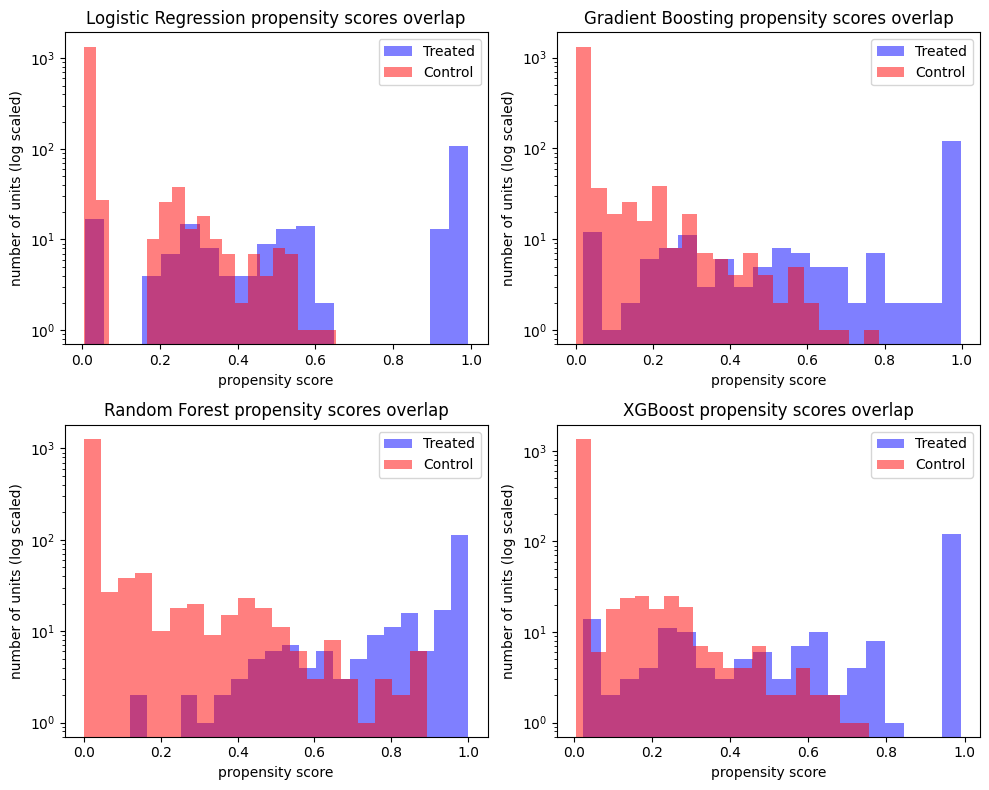

In [155]:
propensities_dict = {
                    'Logistic Regression': lr_propensity_df,
                     'Gradient Boosting': gb_propensity_df,
                     'Random Forest': rf_propensity_df,
                     'XGBoost': xgb_propensity_df
                    }
plot_propensity_models_hist(propensities_dict)

In [156]:
def plot_calibration_curve(models_dict, t_true):
    plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for model_name, propensity_df in models_dict.items():
        propensity = propensity_df['propensity_score']
        fraction_of_positives, mean_predicted_value = calibration_curve(t_true, propensity, n_bins=10)

        ax1.plot(mean_predicted_value,
                 fraction_of_positives,
                 "s-",
                 label=model_name)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration curves')
    ax1.set_xlabel("Mean predicted value")
    plt.tight_layout()
    plt.show()

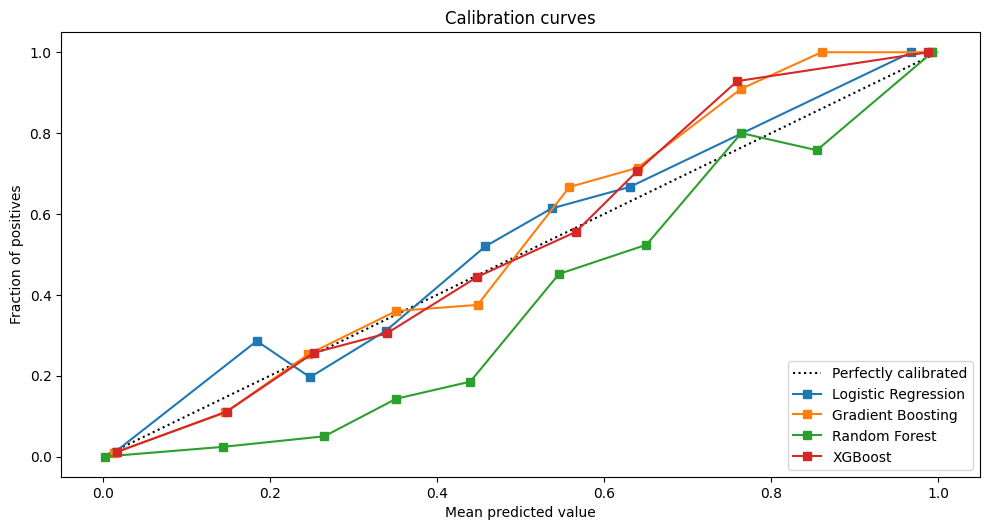

In [157]:
plot_calibration_curve(propensities_dict, features_df[T_BINARY])

In [116]:
def plot_evaluation_metrics(models_dict, t_true):
    scores = []
    for model_name, propensity_df in models_dict.items():
        propensity = propensity_df['propensity_score']
        
        # Calculate the metrics
        logloss = log_loss(t_true, propensity)
        roc_auc = roc_auc_score(t_true, propensity)
        pr_auc = average_precision_score(t_true, propensity)
        
        # Store the results
        scores.append((model_name, 'Log Loss', logloss))
        scores.append((model_name, 'ROC AUC', roc_auc))
        scores.append((model_name, 'PR AUC', pr_auc))
    
    # Convert to a DataFrame for easier plotting
    scores_df = pd.DataFrame(scores, columns=['Model', 'Metric', 'Score'])
    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Metric', y='Score', hue='Model', data=scores_df)
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

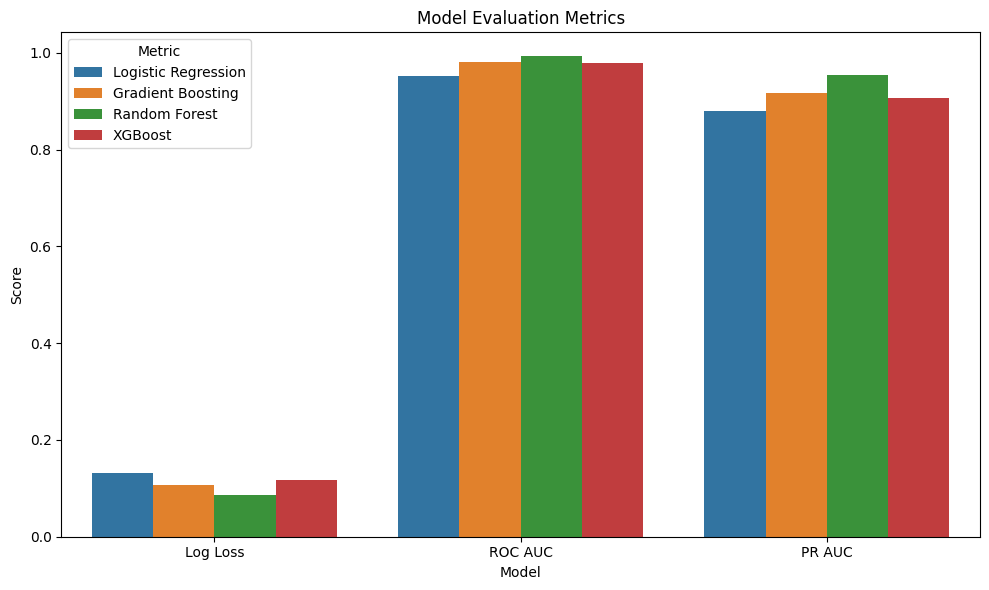

In [158]:
plot_evaluation_metrics(propensities_dict, features_df[T_BINARY])

In [178]:
def estimate_ate_ipw(T, Y, e):
    n = len(T)
    left_argument = sum(T * Y / e)
    right_argument = sum(((1 - T) * Y) / (1 - e))
    return (left_argument - right_argument) / n

In [163]:
estimate_ate_ipw(features_df[T_BINARY], features_df[Y], gb_propensity_df['propensity_score'])

-0.5841885996293308

In [180]:
estimate_ate_ipw(features_df[T_BINARY], features_df[Y], lr_propensity_df['propensity_score'])

0.31113797902504614

In [179]:
estimate_ate_ipw(features_df[T_BINARY], features_df[Y], rf_propensity_df['propensity_score'] + 1e-10)

-1.1530071297534863

In [168]:
estimate_ate_ipw(features_df[T_BINARY], features_df[Y], xgb_propensity_df['propensity_score'])

-0.5089607038067544

In [206]:
import numpy as np
import pandas as pd


def matching(label, propensity, calipher=0.05, replace=True):
    """
    Performs nearest-neighbour matching for a sample of test and control
    observations, based on the propensity scores for each observation.

    :param label: Series that contains the label for each observation.
    :param propensity: Series that contains the propensity score for each observation.
    :param calipher: Bound on distance between observations in terms of propensity score.
    :param replace: Boolean that indicates whether sampling is with (True) or without replacement (False).
    :return: matches
    """
    treated = propensity[label == 1]
    control = propensity[label == 0]

    # Randomly permute in case of sampling without replacement to remove any bias arising from the
    # ordering of the data set
    matching_order = np.random.permutation(label[label == 1].index)
    matches = {}

    for obs in matching_order:
        # Compute the distance between the treatment observation and all candidate controls in terms of
        # propensity score
        distance = abs(treated[obs] - control)

        # Take the closest match
        if distance.min() <= calipher or not calipher:
            matches[obs] = [distance.argmin()]
            # Remove the matched control from the set of candidate controls in case of sampling without replacement
            if not replace:
                control = control.drop(matches[obs])

    return matches


def matching_to_dataframe(match, covariates, remove_duplicates=False):
    """
    Converts a list of matches obtained from matching() to a DataFrame.
    Duplicate rows are controls that where matched multiple times.

    :param match: Dictionary with a list of matched control observations.
    :param covariates: DataFrame that contains the covariates for the observations.
    :param remove_duplicates: Boolean that indicates whether or not to remove duplicate rows from the result.
    If matching with replacement was used you should set this to False
    :return: matching as data frame
    """
    treated = list(match.keys())
    control = [ctrl for matched_list in match.values() for ctrl in matched_list]
    result = pd.concat([covariates.loc[treated], covariates.loc[control]])
    if remove_duplicates:
        return result.groupby(result.index).first()
    else:
        return result
    

def calc_ATE(df):
    Y1 = np.array(df[df[T_BINARY] == 1][Y]).mean()
    Y0 = np.array(df[df[T_BINARY] == 0][Y]).mean()
    delta_all = Y1 - Y0
    return delta_all

In [213]:
lr_propensity_df = lr_propensity_df.reset_index(drop=True)
matches_LR = matching(label=lr_propensity_df[T_BINARY],
                      propensity=lr_propensity_df['propensity_score'],
                      calipher=0.1,
                      replace=True)

matches_data_frame_LR = matching_to_dataframe(match=matches_LR,
                                              covariates=lr_propensity_df,
                                              remove_duplicates=False)

calc_ATE(matches_data_frame_LR)

-0.009602048436999855

In [211]:
gb_propensity_df = gb_propensity_df.reset_index(drop=True)
matches_GB = matching(label=gb_propensity_df[T_BINARY],
                      propensity=gb_propensity_df['propensity_score'],
                      calipher=0.1,
                      replace=True)

matches_data_frame_GB = matching_to_dataframe(match=matches_GB,
                                              covariates=gb_propensity_df,
                                              remove_duplicates=False)

calc_ATE(matches_data_frame_GB)

0.09523809523809534

In [215]:
rf_propensity_df = rf_propensity_df.reset_index(drop=True)
matches_rf = matching(label=rf_propensity_df[T_BINARY],
                      propensity=rf_propensity_df['propensity_score'],
                      calipher=0.1,
                      replace=True)

matches_data_frame_rf = matching_to_dataframe(match=matches_rf,
                                              covariates=rf_propensity_df,
                                              remove_duplicates=False)

calc_ATE(matches_data_frame_rf)

0.08073121665354677

In [216]:
xgb_propensity_df = xgb_propensity_df.reset_index(drop=True)
matches_xgb = matching(label=xgb_propensity_df[T_BINARY],
                      propensity=xgb_propensity_df['propensity_score'],
                      calipher=0.1,
                      replace=True)

matches_data_frame_xgb = matching_to_dataframe(match=matches_xgb,
                                              covariates=xgb_propensity_df,
                                              remove_duplicates=False)

calc_ATE(matches_data_frame_xgb)

0.00010700909577310291